In [2]:
import glob
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import tqdm
import gc
import os
import geopandas as gpd
from sklearn.metrics.pairwise import cosine_similarity
import splot
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from scipy.sparse import issparse
import warnings
import tqdm
import hdf5plugin
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr

def get_R(data1,data2, dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[1]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_MI(adata1, adata2, gene_list, spatial_matrix):
    moran_scores = []
    adata1.obsm["gpd"] = gpd.GeoDataFrame(adata1.obs, geometry=gpd.points_from_xy(spatial_matrix[:, 0], spatial_matrix[:, 1]))
    print("Calculate Moran's I score...")
    for gene in tqdm.tqdm(gene_list):
        x = adata1.to_df()[gene].values
        y = adata2.to_df()[gene].values
        w = Queen.from_dataframe(adata1.obsm["gpd"])
        moran_bv = Moran_BV(y, x, w)
        moran_scores.append(moran_bv.I)
    return moran_scores

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def top_predictable_genes(df_all, dataset, method, num=5,):
    """
    input the results from the make_res function.
    output the top predictable genes with the number of positive Pearson correlation values.
    num is the number of top predictable genes.
    """
    df = df_all[df_all["Method"]==method]
    if num == "pos":
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)
    top5_genes = list(top5_df.index)
    
    # Subset the results according to top predictable gene
    num_pos = []
    for g in top5_genes:
        subset_df = df[df["Gene"]==g]
        count_positive_corr = subset_df[subset_df['Pearson correlation'] > 0].shape[0]
        # print(f'Number of positive Pearson correlation values: {count_positive_corr}')
        num_pos.append(int(count_positive_corr))
    top5_df["Number of consistent samples"] = num_pos
    top5_df["Method"] = method
    top5_df["Dataset"] = dataset
    top5_df = top5_df[[(           'Method',       ''),
            (                     'Dataset',       ''),
            ('Number of consistent samples',       ''),
            (         'Pearson correlation',   'mean'),
            (         'Pearson correlation', 'median'),
            (         'Pearson correlation', 'min'),
            (         'Pearson correlation',    'max'),
            (         'Pearson correlation',    'std'),
            
            ]]

    return top5_df

def make_res(dataset_name, Methods, names, distributed=False,):
    """
    input the dataset name, colornorm, methods, and names of the slides
    output the results of the methods with three metrics: Pearson correlation, Spearman correlation, and SSIM score
    """
    for method in tqdm.tqdm(Methods):
        if distributed:
            gc.collect()
            name = names[fold]
            file_path = f"../Results/Messagepass/gt_{method}_{name}.h5ad"
            if os.path.exists(file_path):
                data1 = sc.read_h5ad(f"../Results/Messagepass/gt_{method}_{name}.h5ad")
                data2 = sc.read_h5ad(f"../Results/Messagepass/pred_{method}_{name}.h5ad")
                spatial_matrix = np.load(f"../Results/Messagepass/spatial_loc_{method}_{name}.npy")
                pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
                SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
                ssim_score = get_ssim(data1, data2)
                cosine_score = get_cosine(data1, data2)
                data1.var_names = data2.var_names
                MI = get_MI(data1, data2, list(data1.var_names), spatial_matrix)
                PCC_BC_Visium = {
                "Gene": list(data1.var_names),
                "Pearson correlation": pcc,
                "PCC_PValue": PCC_PValue,
                "Spearmanr correlation": SPC,
                "SPC_PValue": SPC_PValue,
                "SSIM_Score": ssim_score,
                "Cosine_Score": cosine_score,
                "Moran'I_Score": MI,
                "Slides": [name]*len(pcc),
                "Dataset": [dataset_name]*len(pcc),
                "Method": [method]*len(pcc),}
                
                PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
                if not os.path.isdir(f"../Results/{dataset_name}"):
                    os.mkdir(f"../Results/{dataset_name}")
                PCC_BC_Visium.to_csv(f"../Results/Messagepass/{method}_{name}_MI.csv")
            else:
                print(f"The file {file_path} does not exist. Skipping.")
        else:
            for name in names:
                gc.collect()
                file_path = f"../Results/Messagepass/gt_{method}_{name}.h5ad"
                if os.path.exists(file_path):
                    data1 = sc.read_h5ad(f"../Results/Messagepass/gt_{method}_{name}.h5ad")
                    data2 = sc.read_h5ad(f"../Results/Messagepass/pred_{method}_{name}.h5ad")
                    spatial_matrix = np.load(f"../Results/Messagepass/spatial_loc_{method}_{name}.npy")
                    pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
                    SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
                    ssim_score = get_ssim(data1, data2)
                    cosine_score = get_cosine(data1, data2)
                    data1.var_names = data2.var_names
                    # MI = get_MI(data1, data2, list(data1.var_names), spatial_matrix)
                    PCC_BC_Visium = {
                    "Gene": list(data1.var_names),
                    "Pearson correlation": pcc,
                    "PCC_PValue": PCC_PValue,
                    "Spearmanr correlation": SPC,
                    "SPC_PValue": SPC_PValue,
                    "SSIM_Score": ssim_score,
                    "Cosine_Score": cosine_score,
                    # "Moran'I_Score": MI,
                    "Slides": [name]*len(pcc),
                    "Dataset": [dataset_name]*len(pcc),
                    "Method": [method]*len(pcc),}
                    
                    PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
                    if not os.path.isdir(f"../Results/{dataset_name}"):
                        os.mkdir(f"../Results/{dataset_name}")
                    PCC_BC_Visium.to_csv(f"../Results/Messagepass/{method}_{name}_MI.csv")
                else:
                    print(f"The file {file_path} does not exist. Skipping.")
    print("Organize the results into summary file!")
    res = glob.glob(f"../Results/Messagepass/*_MI.csv")
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])
    df.reset_index(inplace=True)
    df.to_csv(f"../Results/Summary/Messagepass_summary_MI.csv")
    return df


/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_44552/337366124.py:9: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEO

# Message Passing

In [2]:
Methods = ["GAT", "GCN-mean", "GCN-max", "GIN"]
dataset_name = "Messagepass"
names = ['1142243F', '1160920F', 'block1', 'block2', 'FFPE', 'CID4290', 'CID4465', 'CID44971', 'CID4535']
make_res(dataset_name, Methods, names, distributed=False)


100%|██████████| 4/4 [01:54<00:00, 28.53s/it]


Organize the results into summary file!


index      Gene  Pearson correlation  PCC_PValue  \
0          0     TCL1A             0.019811    0.111358   
1          1     NODAL                  NaN         NaN   
2          2      MCM7             0.059665    0.000119   
3          3    COMMD3             0.050404    0.000955   
4          4     VEGFC            -0.040810    0.994008   
...      ...       ...                  ...         ...   
58675   1625     CCL27             0.045602    0.061105   
58676   1626  HLA-DQA1            -0.006572    0.588083   
58677   1627      WNT3             0.065951    0.012660   
58678   1628      NASP             0.009238    0.377161   
58679   1629    MAP3K1            -0.028221    0.830507   

       Spearmanr correlation  SPC_PValue  SSIM_Score  Cosine_Score    Slides  \
0                   0.018147    0.132016    0.002489      0.082367    block1   
1                        NaN         NaN    0.000012      0.000000    block1   
2                   0.047865    0.001602    0.007496      0.769032    block1   
3                   0.048926    0.001294    0.009120      0.845351    block1   
4                  -0.041949    0.995100    0.003488      0.247082    block1   
...                      ...         ...         ...           ...       ...   
58675               0.040210    0.086493   -0.000004     -0.082806  CID44971   
58676               0.017794    0.273321    0.005881      0.756339  CID44971   
58677               0.047725    0.052874    0.002837      0.136920  CID44971   
58678              -0.008652    0.615270    0.007236      0.760027  CID44971   
58679              -0.030956    0.852884    0.004652      0.602902  CID44971   

           Dataset Method  
0      Messagepass    GIN  
1      Messagepass    GIN  
2      Messagepass    GIN  
3      Messagepass    GIN  
4      Messagepass    GIN  
...            ...    ...  
58675  Messagepass    GAT  
58676  Messagepass    GAT  
58677  Messagepass    GAT  
58678  Messagepass    GAT  
58679  Messagepass    GAT  

[58680 rows x 11 columns]

In [59]:
df = pd.read_csv(f"../Results/Summary/Messagepass_summary_MI.csv")
df.sort_values(by=["Slides"], inplace=True)

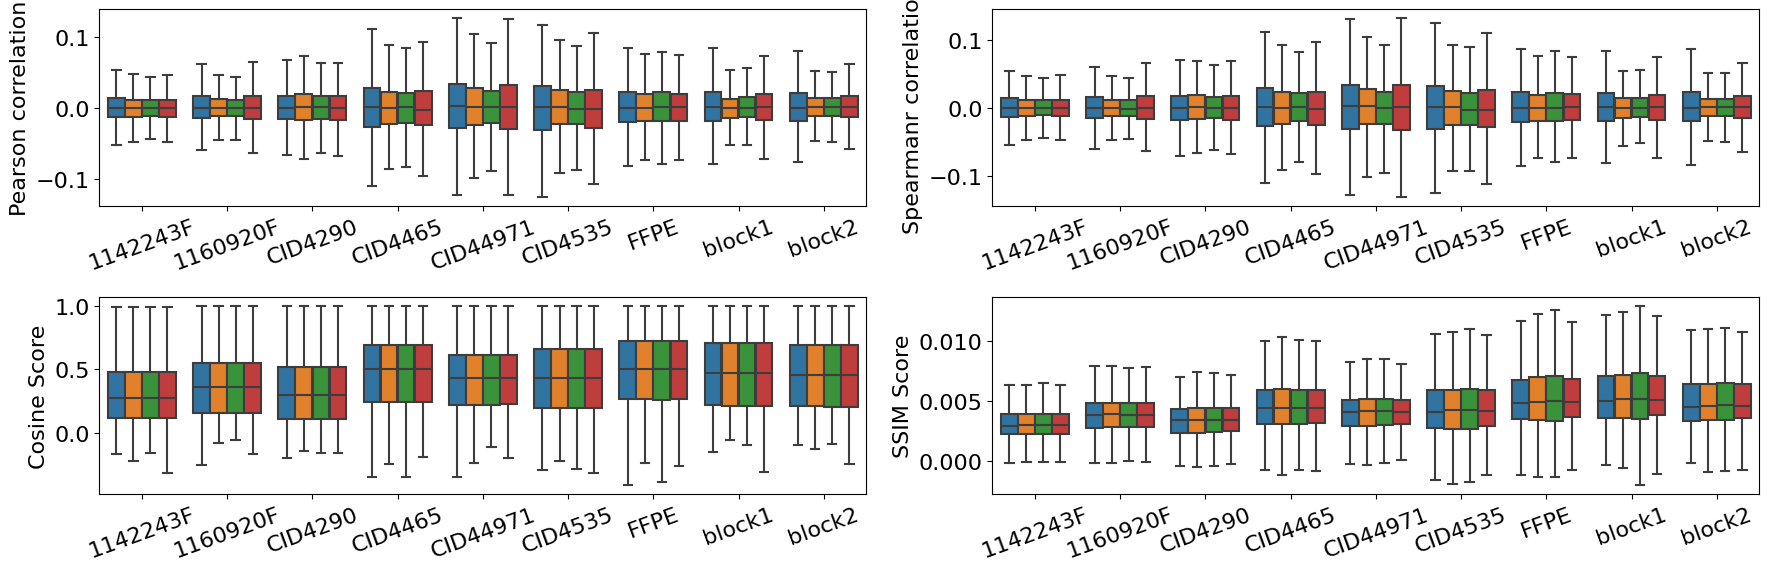

73544

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(18, 6))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x='Slides', y=column, hue='Method', data=df, ax=axs[row_index, col_index], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[row_index, col_index].get_legend().remove()
    
    axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[row_index, col_index].set_ylabel(ylabel)

# # Move the legend outside the plot area only for the first subplot
# pos = axs[0, 0].get_position()
# axs[0, 0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0, 0].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.3),
#     ncol=7,
# )

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure5.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


## Predictable genes

In [48]:
x1 = set(top_predictable_genes(df, "Messagepass", "GAT", num=500).index)
x2 = set(top_predictable_genes(df, "Messagepass", "GCN-mean", num=500).index)
x3 = set(top_predictable_genes(df, "Messagepass", "GCN-max", num=500).index)
x4 = set(top_predictable_genes(df, "Messagepass", "GIN", num=500).index)
predictable_genes = list(x1.intersection(x2, x3, x4))
print(f"There are {len(predictable_genes)} genes that are predictable by all methods.")
predictable_genes

There are 17 genes that are predictable by all methods.


['MAGEC1',
 'BCOR',
 'MMP9',
 'ALCAM',
 'EPCAM',
 'CD19',
 'IL1RN',
 'AFDN',
 'FN1',
 'CACNA1H',
 'TNFAIP3',
 'CYSLTR2',
 'GZMK',
 'CLEC6A',
 'RBX1',
 'FYB1',
 'CD38']

In [49]:
# df1 is the results for predictable genes (subset of df)
df1 = df[df["Gene"].isin(predictable_genes)]
df1 = df1.reset_index().drop("index",axis=1)

# df2 is summary information for comparing methods
df2 = df1[["Method", "Pearson correlation"]].groupby("Method", as_index=False).agg(['median', 'mean', 'max', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
df2

Pearson correlation                              
                      median      mean       max       std
Method                                                    
GAT                 0.015046  0.016200  0.154952  0.041360
GCN-max             0.013234  0.013889  0.103155  0.028559
GCN-mean            0.012881  0.013655  0.100770  0.033778
GIN                 0.012181  0.014065  0.264612  0.041977

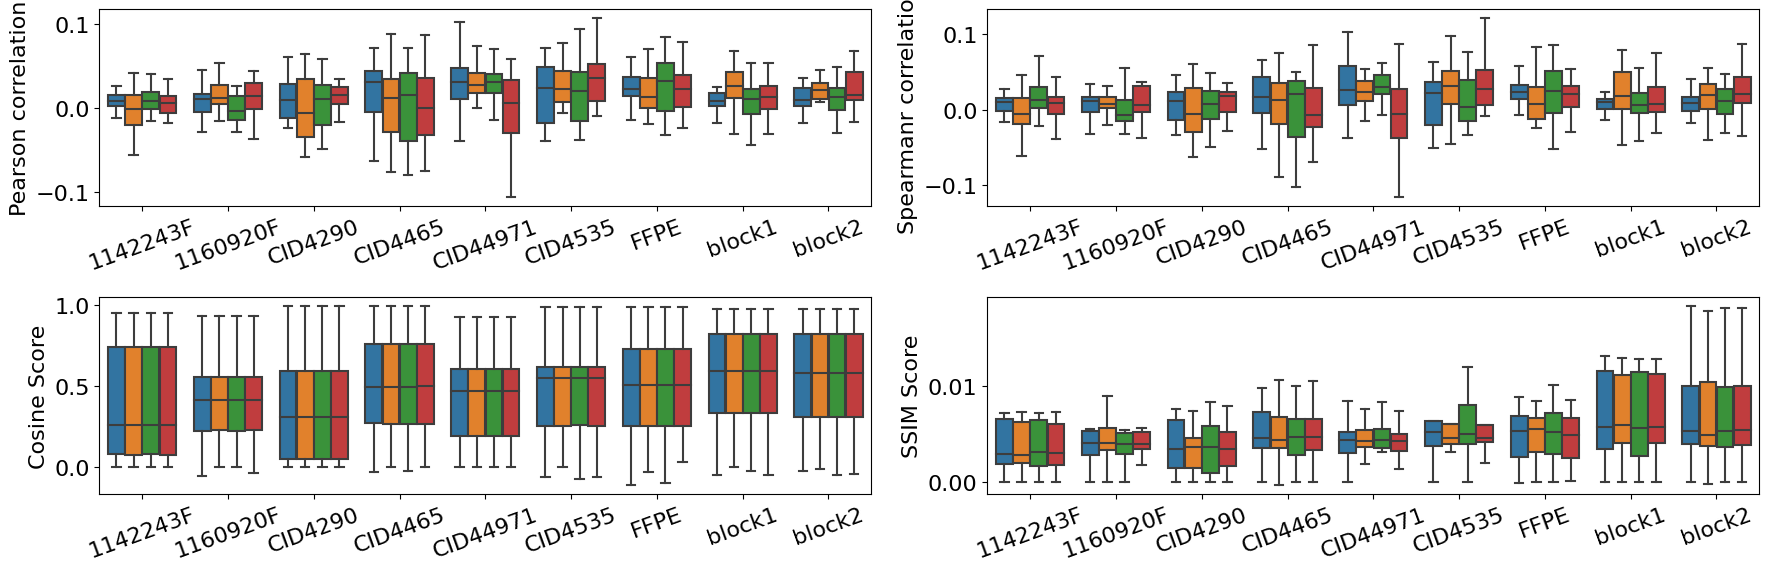

73024

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(18, 6))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x='Slides', y=column, hue='Method', data=df1, ax=axs[row_index, col_index], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[row_index, col_index].get_legend().remove()
    
    axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[row_index, col_index].set_ylabel(ylabel)

# # Move the legend outside the plot area only for the first subplot
# pos = axs[0, 0].get_position()
# axs[0, 0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0, 0].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.3),
#     ncol=7,
# )

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure5.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


# Graph Construction

In [ ]:
Methods = ["Default", "PAG_GAG", "PAG", "GAG"]
slides = ['1160920F', '1142243F', 'CID44971', 'CID4535', 'CID4465', 'CID4290', 'FFPE', 'block1', 'block2']

data1 = sc.read_h5ad(glob.glob(f"../Results/Graphconstruct/{method}/pred_BC_visium_{slide}*.h5ad")[0])
data2 = sc.read_h5ad(glob.glob(f"../Results/Graphconstruct/{method}/gt_BC_visium_{slide}*.h5ad")[0]) 

In [39]:
# Read the method names
Methods = ["Default", "PAG_GAG", "PAG", "GAG"]

# Organize the results into a dataframe
for method in tqdm.tqdm(Methods):
    # Read the slide names
    slides = ['1160920F', '1142243F', 'CID44971', 'CID4535', 'CID4465', 'CID4290', 'FFPE', 'block1', 'block2']
    for slide in slides:
        gc.collect()
        data1 = sc.read_h5ad(glob.glob(f"../Results/Graphconstruct/{method}/pred_BC_visium_{slide}*.h5ad")[0])
        data2 = sc.read_h5ad(glob.glob(f"../Results/Graphconstruct/{method}/gt_BC_visium_{slide}*.h5ad")[0])
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        PCC_BC_Visium = {
        "Gene": list(data2.var_names),
        "Pearson correlation": pcc,
        "PCC_PValue": PCC_PValue,
        "Spearmanr correlation": SPC,
        "SSIM_Score": ssim_score,
        "Cosine_Score": cosine_score,
        "SPC_PValue": SPC_PValue,
        "Slides": [slide]*len(pcc),
        "Method": [method]*len(pcc),
        "Dataset": ["BC_visium"]*len(pcc)
        }
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
        if not os.path.isdir(f"../Results/Graphconstruct/"):
            os.mkdir(f"../Results/Graphconstruct/")
        PCC_BC_Visium.to_csv(f"../Results/Graphconstruct/{method}_{slide}.csv")

print("Organize the results into summary file!")
if not os.path.isdir(f"../Results/Summary/Graphconstruct"):
    os.mkdir(f"../Results/Summary/Graphconstruct")
res = glob.glob(f"../Results/Graphconstruct/*.csv")
df = [pd.read_csv(i, index_col=[0]) for i in res]
df = pd.concat(df)
df.to_csv(f"../Results/Summary/Graphconstruct/Graph_construction_Summary.csv")
df 


100%|██████████| 4/4 [01:30<00:00, 22.70s/it]


Organize the results into summary file!


Gene  Pearson correlation    PCC_PValue  Spearmanr correlation  \
0         ABL1             0.040524  2.390253e-03               0.042220   
1         ABL2             0.027678  2.701198e-02               0.032721   
2     ABRAXAS1            -0.013464  8.256330e-01              -0.011434   
3        ACTN1             0.079503  1.496767e-08               0.070741   
4        ACTN4             0.097165  6.080447e-12               0.088150   
...        ...                  ...           ...                    ...   
1625      XBP1             0.248636  6.504318e-55               0.295680   
1626      XCR1            -0.000068  5.016591e-01              -0.010192   
1627    YTHDF2             0.182653  3.776320e-30               0.178436   
1628     ZAP70             0.080415  3.484592e-07               0.075370   
1629    ZNF205             0.108596  9.718448e-12               0.131290   

      SSIM_Score  Cosine_Score    SPC_PValue    Slides Method    Dataset  
0       0.021386      0.456803  1.642887e-03  1160920F    PAG  BC_visium  
1       0.015164      0.364219  1.136912e-02  1160920F    PAG  BC_visium  
2       0.001133      0.222909  7.869195e-01  1160920F    PAG  BC_visium  
3       0.053719      0.729528  4.124391e-07  1160920F    PAG  BC_visium  
4       0.066820      0.801933  3.954144e-10  1160920F    PAG  BC_visium  
...          ...           ...           ...       ...    ...        ...  
1625    0.221425      0.949299  8.458306e-78    block1    GAG  BC_visium  
1626   -0.004165     -0.009968  7.349671e-01    block1    GAG  BC_visium  
1627    0.134897      0.749405  7.664700e-29    block1    GAG  BC_visium  
1628    0.047864      0.416965  1.659762e-06    block1    GAG  BC_visium  
1629    0.078020      0.563900  2.261715e-16    block1    GAG  BC_visium  

[58680 rows x 10 columns]

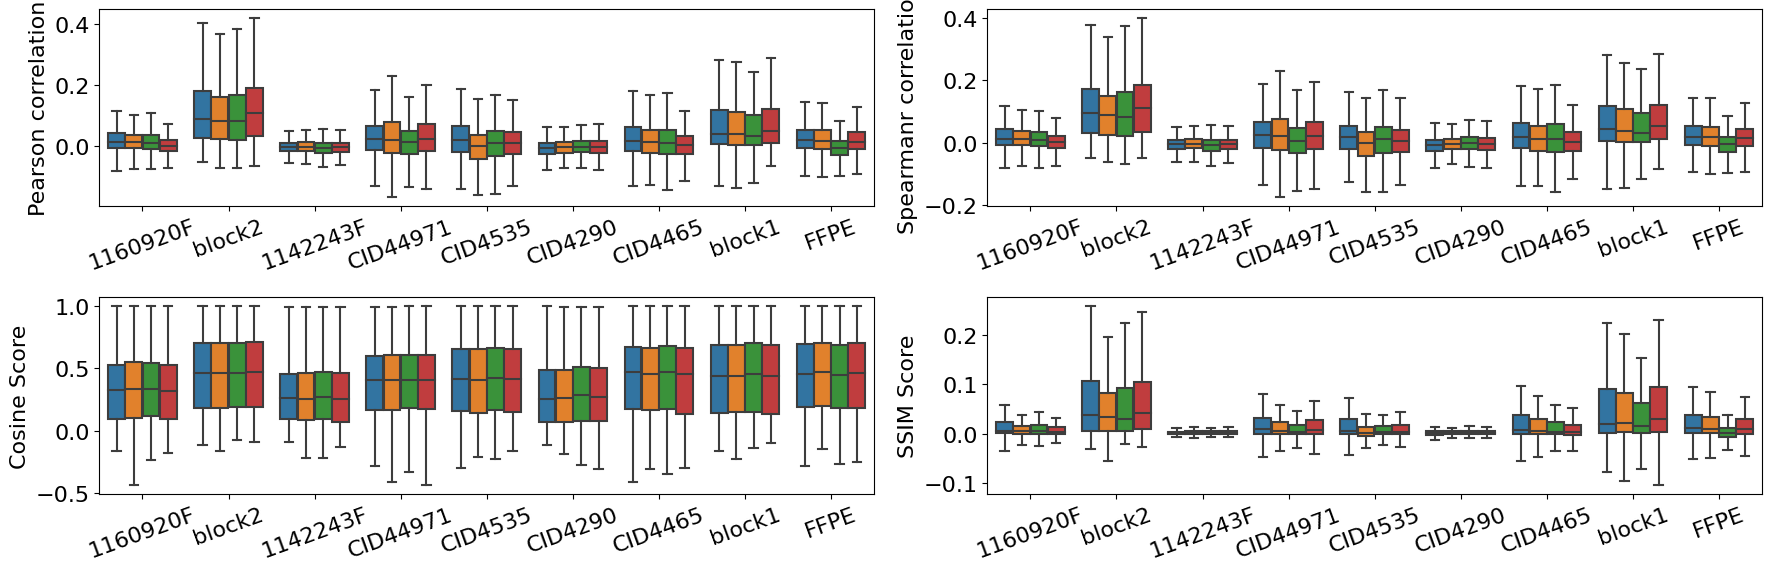

73338

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(18, 6))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x='Slides', y=column, hue='Method', data=df, ax=axs[row_index, col_index], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[row_index, col_index].get_legend().remove()
    
    axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[row_index, col_index].set_ylabel(ylabel)

# # Move the legend outside the plot area only for the first subplot
# pos = axs[0, 0].get_position()
# axs[0, 0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0, 0].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.3),
#     ncol=7,
# )

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure5.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


In [61]:
df = pd.read_csv(f"../Results/Summary/Graphconstruct/Graph_construction_Summary.csv")
x1 = set(top_predictable_genes(df, "BC_Visium", "Default", num=500).index)
x2 = set(top_predictable_genes(df, "BC_Visium", "PAG_GAG", num=500).index)
x3 = set(top_predictable_genes(df, "BC_Visium", "PAG", num=500).index)
x4 = set(top_predictable_genes(df, "BC_Visium", "GAG", num=500).index)
predictable_genes = list(x1.intersection(x2, x3, x4))
print(f"There are {len(predictable_genes)} genes that are predictable by all methods.")
predictable_genes

There are 228 genes that are predictable by all methods.


['SBNO2',
 'TAPBP',
 'HDAC1',
 'NF1',
 'ACTN1',
 'PRKCD',
 'POLB',
 'VEGFA',
 'FUBP1',
 'ELK1',
 'BCL2L11',
 'ASF1A',
 'XPO1',
 'BAD',
 'KEAP1',
 'TRAF2',
 'TPX2',
 'GATA3',
 'IER3',
 'WEE1',
 'ARHGEF7',
 'AXIN1',
 'TRAF7',
 'DNMT3A',
 'COL1A1',
 'PLA2G6',
 'SERPINE1',
 'DUSP4',
 'DDX3X',
 'GNA11',
 'PRKCI',
 'PHF6',
 'IGHA1',
 'PSMB7',
 'AKT2',
 'DNMT1',
 'UBE3A',
 'TET2',
 'DIS3',
 'S100A9',
 'TK1',
 'CRKL',
 'DNAJB1',
 'SOS1',
 'IL13RA1',
 'TBK1',
 'SMARCB1',
 'ATR',
 'ABL1',
 'MTOR',
 'EZH2',
 'CAST',
 'HDAC11',
 'ARID1B',
 'DHX15',
 'FADD',
 'TFRC',
 'TGFBI',
 'AFDN',
 'PDIA6',
 'FH',
 'COMMD3',
 'G6PD',
 'ITGB4',
 'BID',
 'GTF2I',
 'NUP107',
 'MAP3K13',
 'CDC73',
 'BRD4',
 'ARID1A',
 'CDK4',
 'DHX9',
 'PIK3CB',
 'CASP3',
 'RRM2',
 'CAPN2',
 'MYH9',
 'RPAIN',
 'LRBA',
 'ITGB1',
 'ID2',
 'IGF2R',
 'HSPA1A',
 'MAX',
 'SP1',
 'RHOA',
 'PRKAR2B',
 'MAP3K7',
 'MAPK9',
 'GPI',
 'KMT2C',
 'COL11A1',
 'HMGB1',
 'SF3B1',
 'FUT8',
 'ATG12',
 'BRAF',
 'MCM2',
 'DDX41',
 'MED12',
 'HUWE1',
 '

In [62]:
# df1 is the results for predictable genes (subset of df)
df1 = df[df["Gene"].isin(predictable_genes)]
df1 = df1.reset_index().drop("index",axis=1)

# df2 is summary information for comparing methods
df2 = df1[["Method", "Pearson correlation"]].groupby("Method", as_index=False).agg(['median', 'mean', 'max', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
df2

Pearson correlation                              
                     median      mean       max       std
Method                                                   
PAG                0.073485  0.084114  0.460895  0.087701
PAG_GAG            0.063605  0.077988  0.451247  0.082810
GAG                0.046120  0.067509  0.499872  0.090927
Default            0.043488  0.064297  0.454961  0.088364

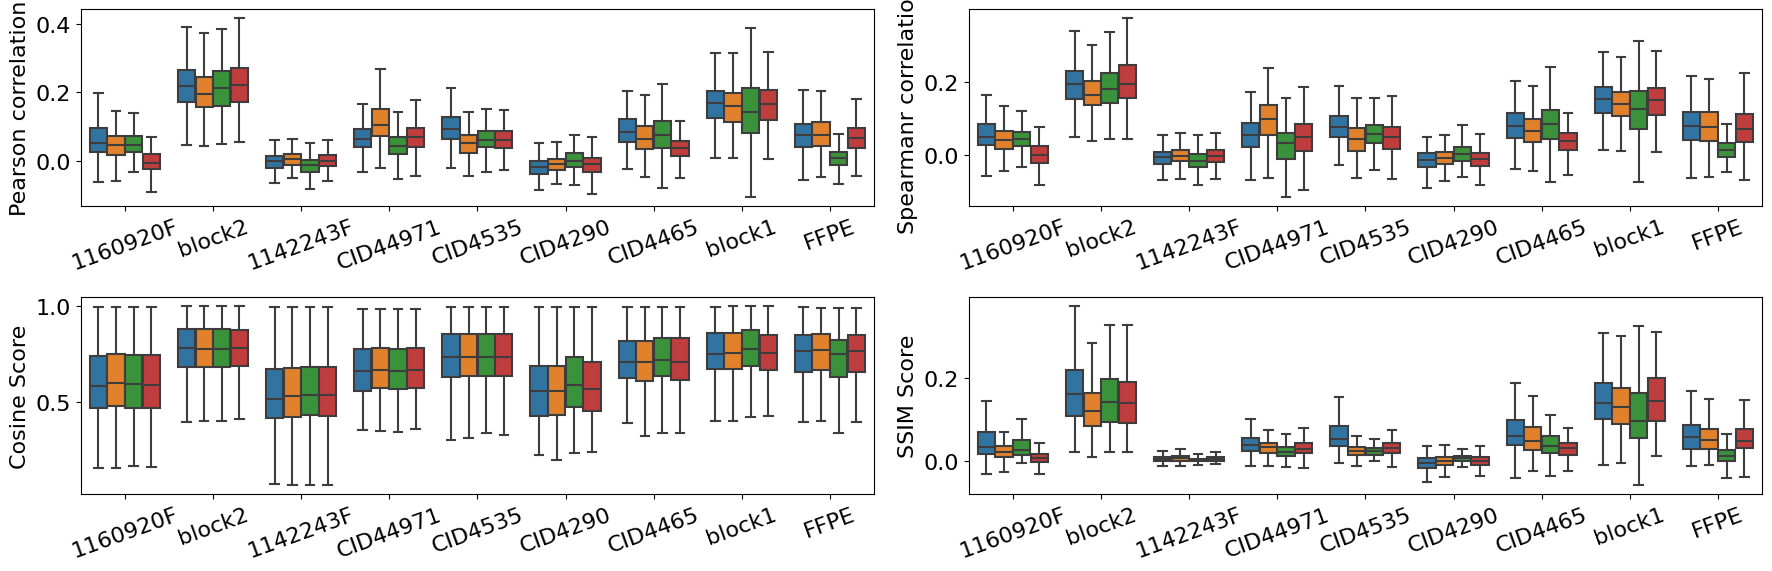

74898

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(18, 6))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x='Slides', y=column, hue='Method', data=df1, ax=axs[row_index, col_index], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[row_index, col_index].get_legend().remove()
    
    axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[row_index, col_index].set_ylabel(ylabel)

# # Move the legend outside the plot area only for the first subplot
# pos = axs[0, 0].get_position()
# axs[0, 0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0, 0].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.3),
#     ncol=7,
# )

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure5.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


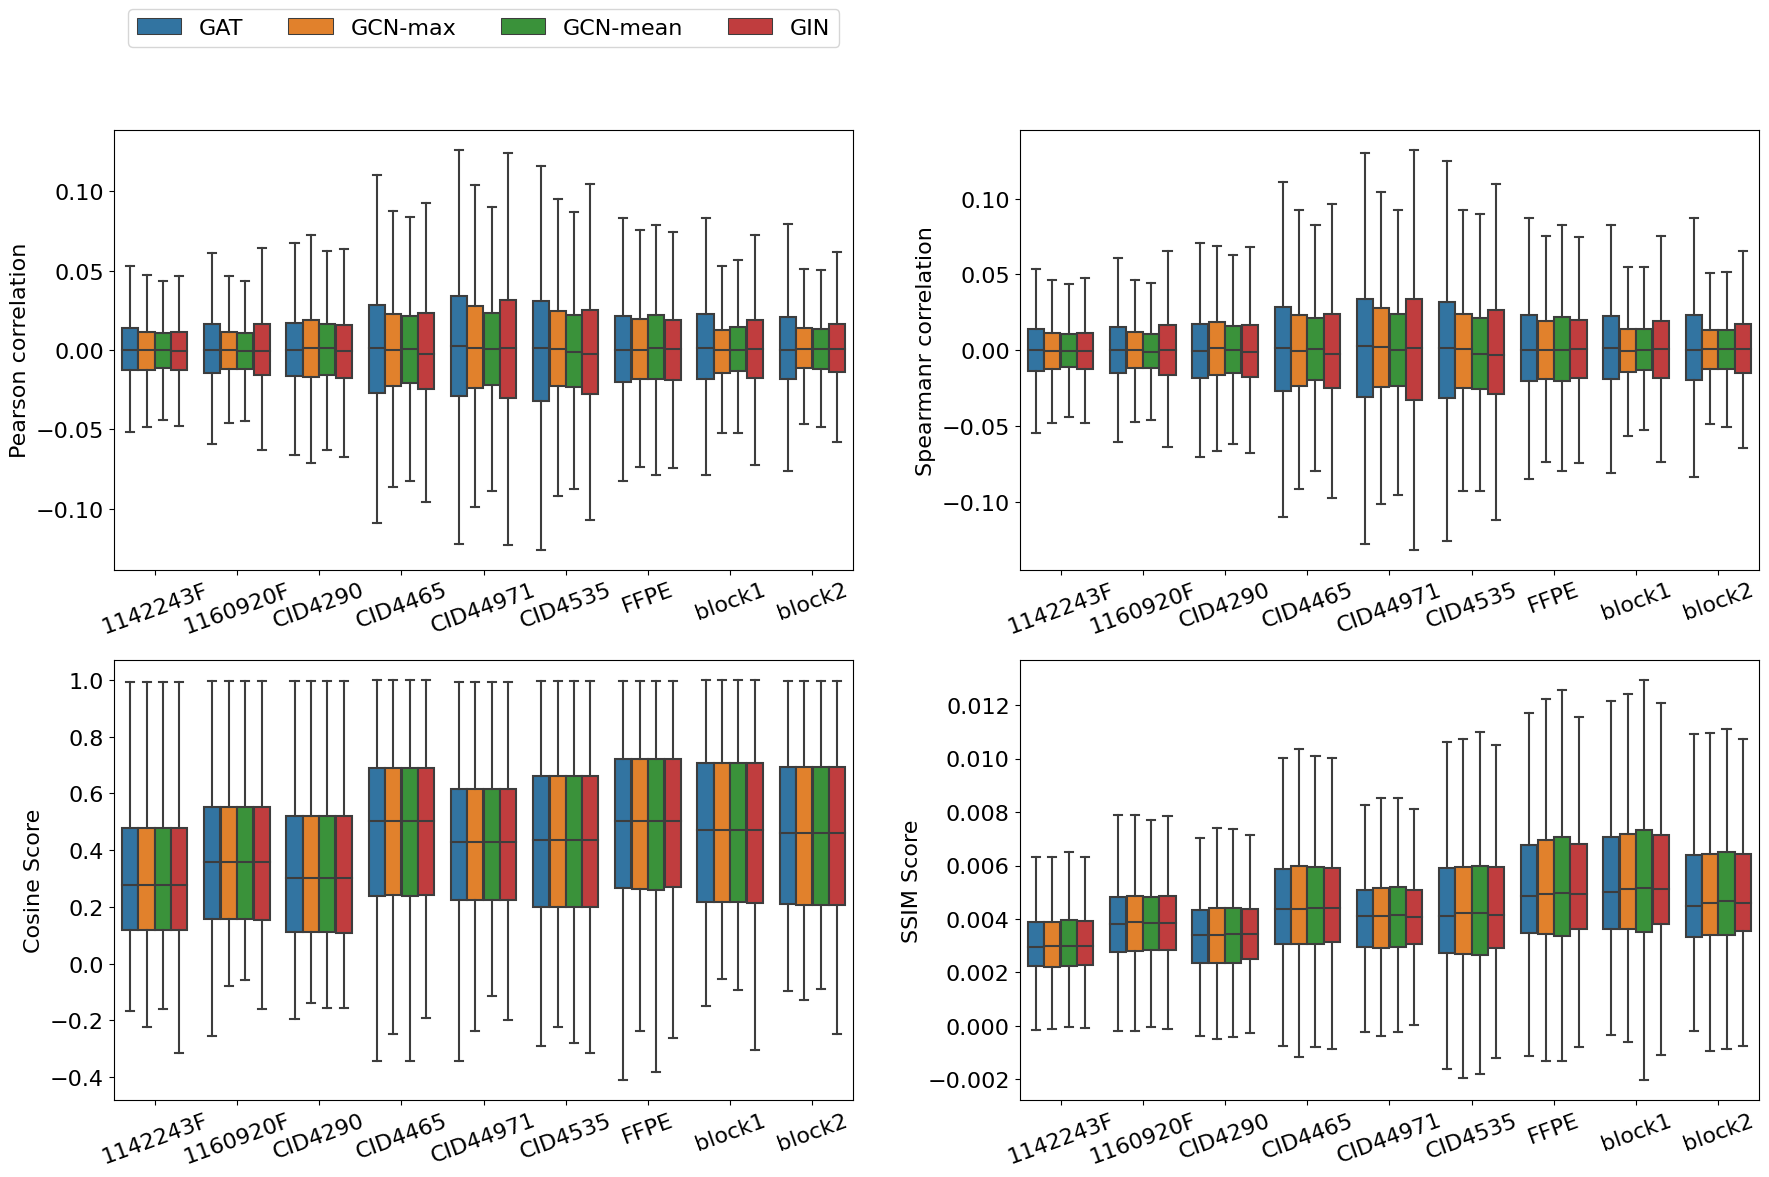

75641

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x='Slides', y=column, hue='Method', data=df, ax=axs[row_index, col_index], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[row_index, col_index].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[row_index, col_index].get_legend().remove()
    
    axs[row_index, col_index].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[row_index, col_index].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0, 0].get_position()
axs[0, 0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0, 0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.3),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure5.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


# Clustering analysis

In [3]:
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import squidpy as sq
import gc
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari_score, normalized_mutual_info_score as nmi_score

import torch
import torch.nn as nn
import sys
sys.path.append("../../")
from torch.utils.data import DataLoader


In [4]:

def Space_region_detection(tmp, color="Grouped annotations", title="Ground truth"):
    """
    Perform space region detection using PCA and KMeans clustering.

    Parameters:
    - tmp: AnnData object
    - color: Column name for color annotations (default: "Grouped annotations")
    - title: Title for the plot (default: "Ground truth")

    Returns:
    - tmp: Updated AnnData object
    - ari: Adjusted Rand Index
    - nmi: Normalized Mutual Information
    """
    # Dimensionality reduction
    sc.pp.pca(tmp)

    # Label encoding
    unique_lbl = set(tmp.obs[color])
    dict1 = {list(unique_lbl)[key]: key for key in range(len(unique_lbl))}
    tmp.obs["lbl"] = tmp.obs[color].map(dict1)
    l = tmp.obs["lbl"].to_numpy()

    # Clustering
    kmeans = KMeans(n_clusters=len(tmp.obs["lbl"].unique()), init="k-means++", random_state=0).fit(tmp.obsm['X_pca'])
    p = kmeans.labels_.astype(str)
    tmp.obs['cluster'] = p

    # Clustering performance assessment
    ari = round(ari_score(p, l), 3)
    nmi = round(nmi_score(p, l), 3)
    # print(f"ari_score: {ari}")
    # print(f"nmi_score: {nmi}")

    gc.collect()
    return tmp, ari, nmi

def organize_res(aris, nmis):
    """
    Organize clustering results into a DataFrame.

    Parameters:
    - aris: List of Adjusted Rand Indices
    - nmis: List of Normalized Mutual Informations

    Returns:
    - df1: DataFrame containing ARI and NMI for each slide
    """
    df1 = pd.DataFrame(aris, index=[0]).T
    df2 = pd.DataFrame(nmis, index=[0]).T
    df1.columns = ["ARI"]
    df2.columns = ["NMI"]
    df1['NMI'] = df2.NMI
    df1["Slides"] = df1.index
    return df1


In [5]:
label_mapping = {
        'Invasive cancer + stroma + lymphocytes': 'Cancer',
        'Invasive cancer + stroma': 'Cancer',
        'Stroma': 'Immune',
        'Invasive cancer + lymphocytes': 'Cancer',
        'Necrosis': 'Other',
        'Invasive cancer': 'Cancer',
        'Lymphocytes': 'Immune',
        'DCIS': 'Cancer',
        'Normal glands + lymphocytes': 'Immune',
        'Normal + stroma + lymphocytes': 'Immune',
        'Artefact': 'Other',
        'Stroma + adipose tissue': 'Immune',
        'Adipose tissue': 'Immune',
        'Uncertain': 'Other',
        'TLS': 'Immune',
        'Cancer trapped in lymphocyte aggregation': 'Immune',
        'Invasive cancer + adipose tissue + lymphocytes': 'Cancer',
        'Normal duct': 'Normal'
    }

In [62]:
name_slides = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535"]
Methods = ["Default", "PAG_GAG", "PAG", "GAG"]
slides = ['1160920F', '1142243F', 'CID44971', 'CID4535', 'CID4465', 'CID4290']
method = Methods[0]
slide = slides[0]
data1 = sc.read_h5ad(glob.glob(f"../Results/Graphconstruct/{method}/gt_BC_visium_{slide}*.h5ad")[0])
data2 = sc.read_h5ad(glob.glob(f"../Results/Graphconstruct/{method}/pred_BC_visium_{slide}*.h5ad")[0])
tmp = sc.read_h5ad(f"../Dataset/BC_visium/{slide}.h5ad")
data1.obsm = tmp.obsm
data1.uns = tmp.uns
data1.obs = tmp.obs
sq.pl.spatial_scatter(data1, color="Grouped annotations", frameon=False, title=f"{method}")

In [ ]:
# Assuming Space_region_detection is a function defined elsewhere in your code
name_slides = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535']

# Lists to collect ARI, NMI, method names, and name_slides
aris = []
nmis = []
methods = []
name_slides_list = []

fig, axs = plt.subplots(len(name_slides), 6, figsize=(30, 40))

# Loop over folds
for fold in range(len(name_slides)):
    name = name_slides[fold]
    
    # Ground Truth (Pathology annotation)
    gt = sc.read_h5ad(f"../Results/Messagepass/gt_GIN_{name}.h5ad")
    tmp = sc.read_h5ad(f"../Dataset/BC_visium/{name}.h5ad")
    gt.uns = tmp.uns
    sq.pl.spatial_scatter(gt, color="Grouped annotations", frameon=False, title=f"Pathology annotation", legend_fontsize="x-large", ax=axs[fold][0])
    axs[fold][0].set_title("Pathology annotation", fontsize="x-large")  # Set title font size


    # Observation
    # print("Observation Gene Expression.")
    gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
    aris.append(pred_ari)
    nmis.append(pred_nmi)
    methods.append("Observation")
    name_slides_list.append(name)
    sq.pl.spatial_scatter(gt, color="cluster", title=f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", 
                  frameon=False, legend_fontsize="large", ax=axs[fold][1])
    axs[fold][1].set_title(f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", fontsize="x-large")  # Set title font size
    

    # Prediction
    for i, model_name in enumerate(["GAT", "GCN-mean", "GCN-max", "GIN"]):
        pred = sc.read_h5ad(f"../Results/Graphconstruct/pred_{model_name}_{name}.h5ad")
        gt = sc.read_h5ad(f"../Results/Graphconstruct/gt_{model_name}_{name}.h5ad")
        gt.X = pred.X
        gt.uns = tmp.uns

        # # Rename models for better visualization
        # model_name_display = {
        #     "stimage": "STimage",
        #     "stnet": "STNet",
        #     "hist2st": "Hist2ST",
        #     "histogene": "HisToGene",
        #     "deepspace": "DeepSpaCE",
        #     "deeppt": "DeepPT",
        #     "bleep": "BLEEP"
        # }.get(model_name, model_name)
        
        gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
        aris.append(pred_ari)
        nmis.append(pred_nmi)
        # methods.append(model_name_display)
        name_slides_list.append(name)
        
        sq.pl.spatial_scatter(gt, color="cluster", title=f"{model_name}\nARI:{pred_ari} NMI:{pred_nmi}", 
                frameon=False, legend_fontsize="x-large", ax=axs[fold][i+2])
        ax=axs[fold][i+2].set_title(f"{model_name}\nARI:{pred_ari} NMI:{pred_nmi}", fontsize="x-large")  # Set title font size
        gc.collect()
    
    for i in range(6):
        for j in range(6):
            # Move legend to the bottom of the plot
            axs[j][i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
        
    plt.savefig(f"Graphconstruct_clustering.pdf")
    gc.collect()

# # Create a DataFrame at the end
# result_df = pd.DataFrame({'Name_Slides': name_slides_list, 'Method': methods, 'ARI': aris, 'NMI': nmis})
# result_df.to_csv("cluster_results.csv", index=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

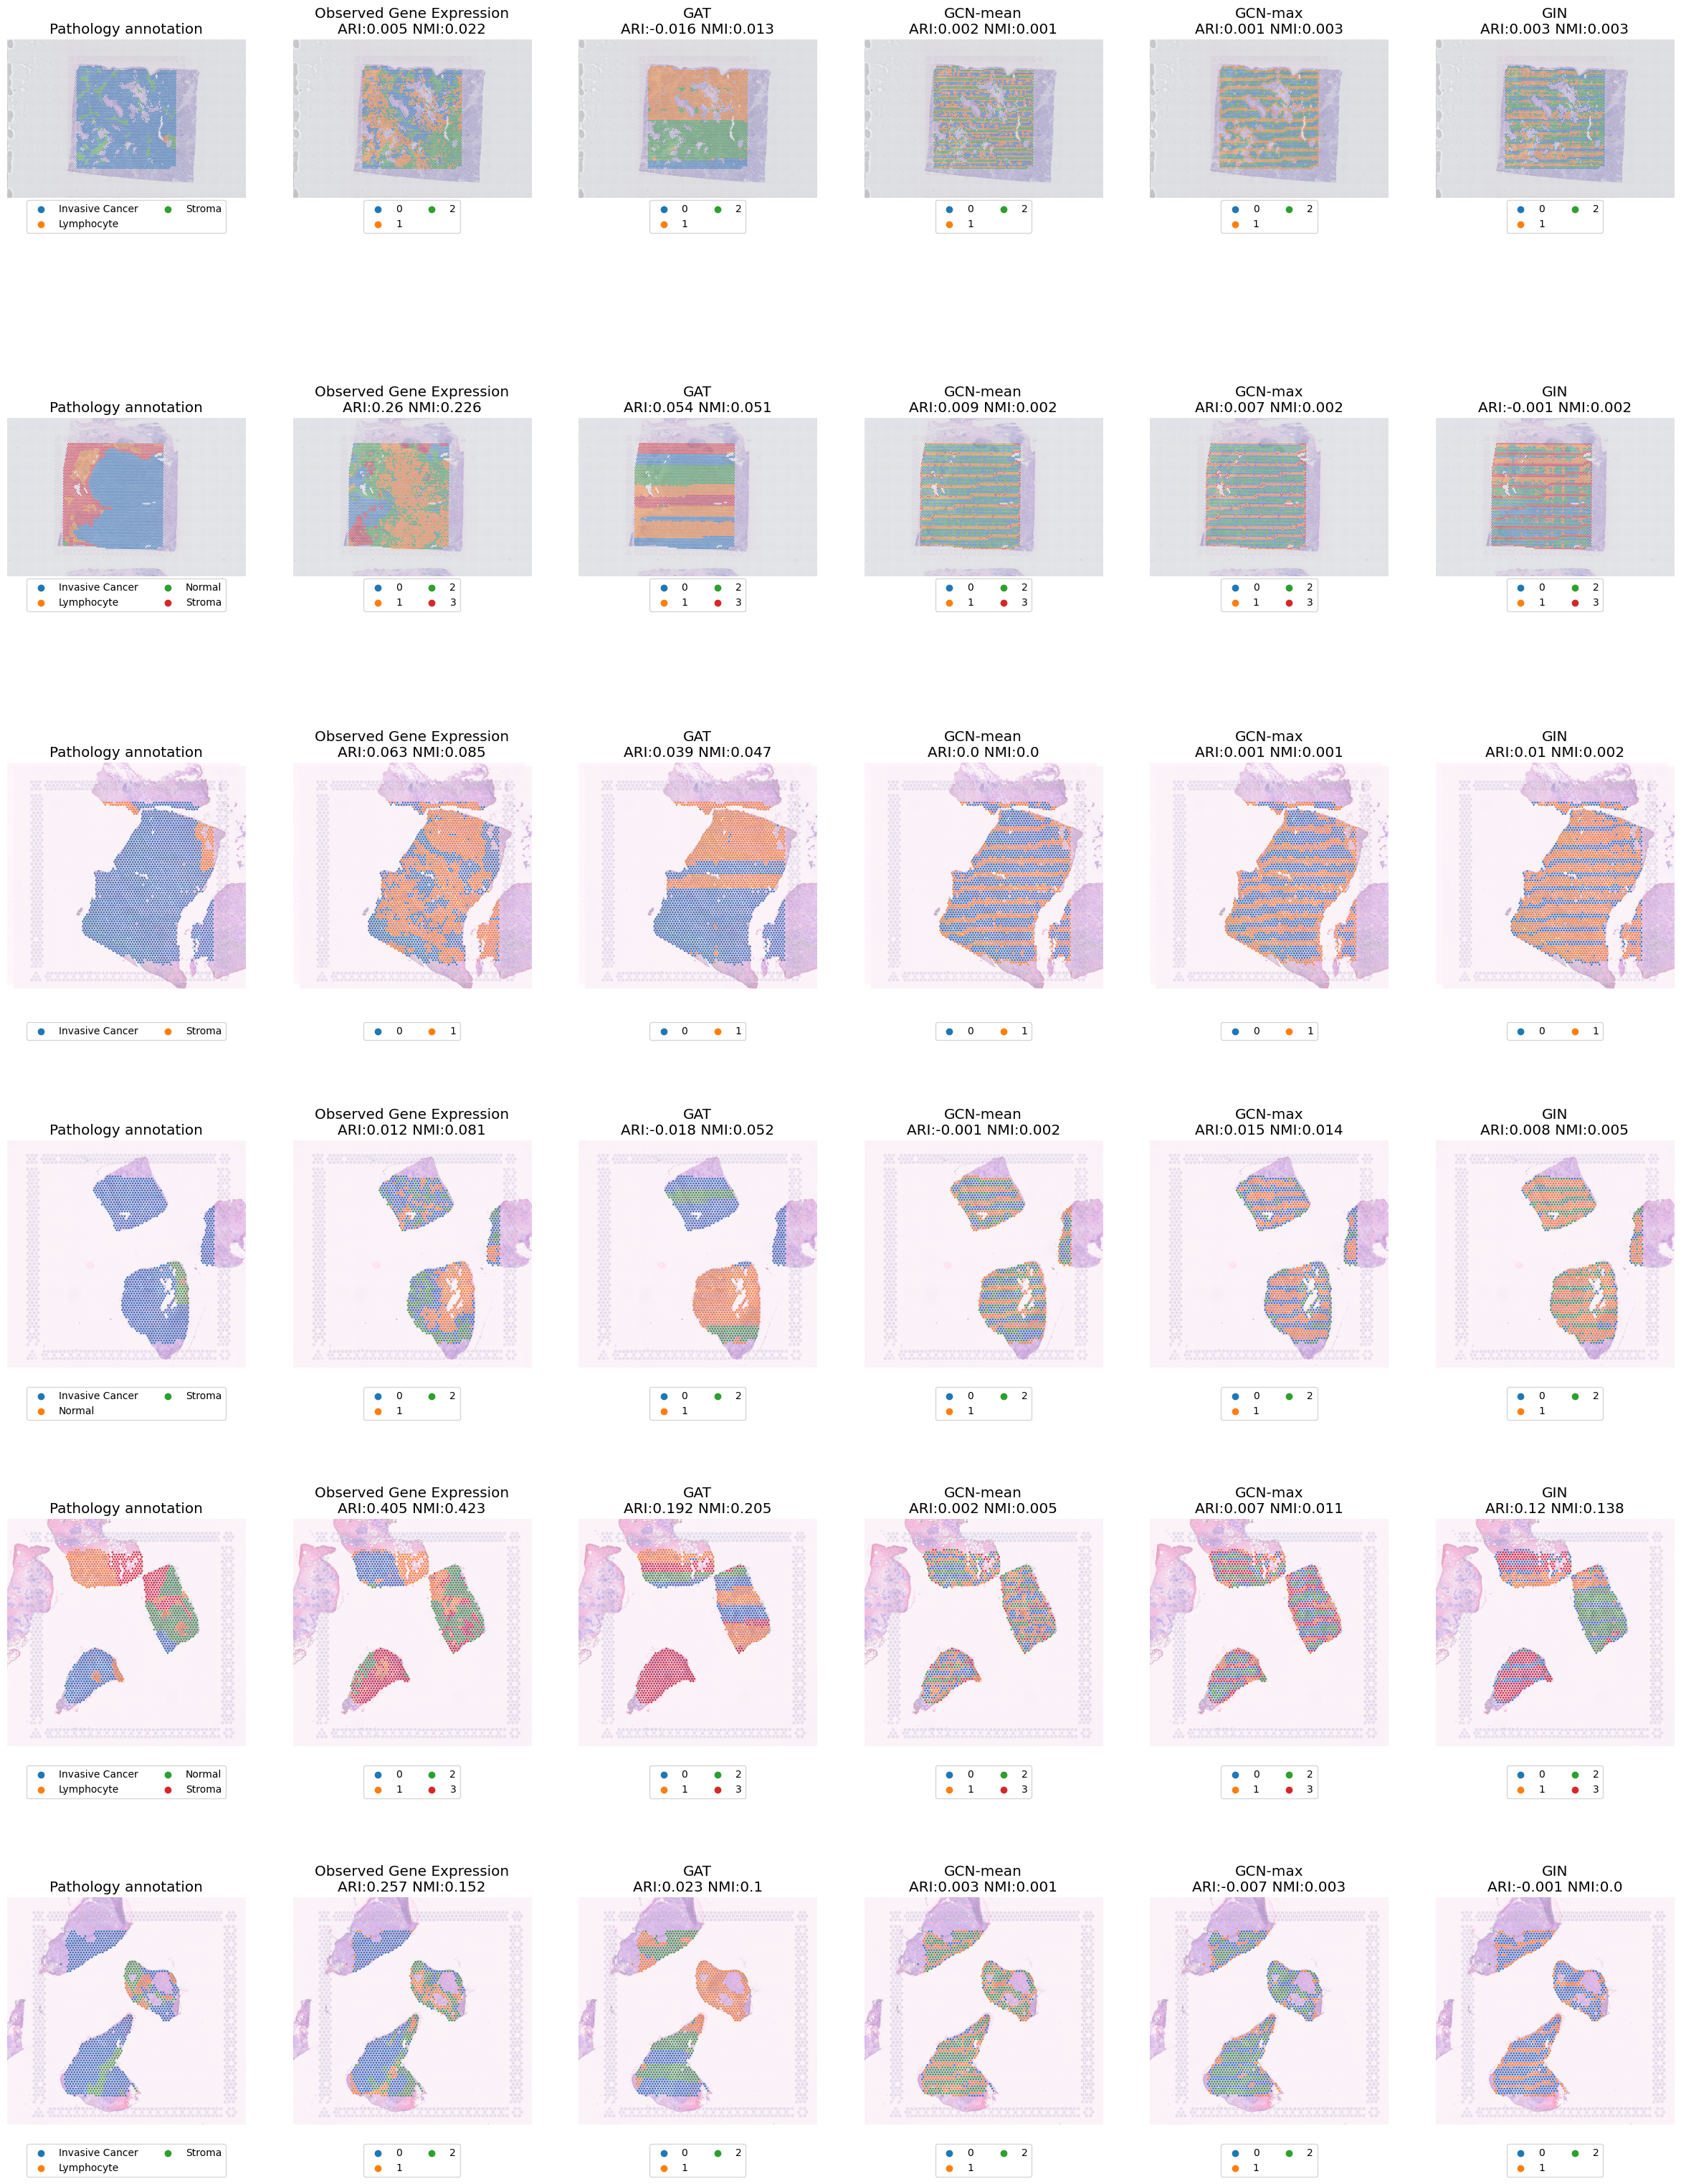

In [28]:
# Assuming Space_region_detection is a function defined elsewhere in your code
name_slides = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535']

# Lists to collect ARI, NMI, method names, and name_slides
aris = []
nmis = []
methods = []
name_slides_list = []

fig, axs = plt.subplots(len(name_slides), 6, figsize=(30, 40))

# Loop over folds
for fold in range(len(name_slides)):
    name = name_slides[fold]
    
    # Ground Truth (Pathology annotation)
    gt = sc.read_h5ad(f"../Results/Messagepass/gt_GIN_{name}.h5ad")
    tmp = sc.read_h5ad(f"../Dataset/BC_visium/{name}.h5ad")
    gt.uns = tmp.uns
    sq.pl.spatial_scatter(gt, color="Grouped annotations", frameon=False, title=f"Pathology annotation", img_alpha=0.4,
                          legend_fontsize="x-large", ax=axs[fold][0])
    axs[fold][0].set_title("Pathology annotation", fontsize="x-large")  # Set title font size


    # Observation
    # print("Observation Gene Expression.")
    gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
    aris.append(pred_ari)
    nmis.append(pred_nmi)
    methods.append("Observation")
    name_slides_list.append(name)
    sq.pl.spatial_scatter(gt, color="cluster", title=f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", img_alpha=0.4,
                  frameon=False, legend_fontsize="large", ax=axs[fold][1])
    axs[fold][1].set_title(f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", fontsize="x-large")  # Set title font size
    

    # Prediction
    for i, model_name in enumerate(["GAT", "GCN-mean", "GCN-max", "GIN"]):
        pred = sc.read_h5ad(f"../Results/Messagepass/pred_{model_name}_{name}.h5ad")
        gt = sc.read_h5ad(f"../Results/Messagepass/gt_{model_name}_{name}.h5ad")
        gt.X = pred.X
        gt.uns = tmp.uns

        # # Rename models for better visualization
        # model_name_display = {
        #     "stimage": "STimage",
        #     "stnet": "STNet",
        #     "hist2st": "Hist2ST",
        #     "histogene": "HisToGene",
        #     "deepspace": "DeepSpaCE",
        #     "deeppt": "DeepPT",
        #     "bleep": "BLEEP"
        # }.get(model_name, model_name)
        
        gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
        aris.append(pred_ari)
        nmis.append(pred_nmi)
        # methods.append(model_name_display)
        name_slides_list.append(name)
        
        sq.pl.spatial_scatter(gt, color="cluster", title=f"{model_name}\nARI:{pred_ari} NMI:{pred_nmi}", img_alpha=0.4, 
                frameon=False, legend_fontsize="x-large", ax=axs[fold][i+2])
        ax=axs[fold][i+2].set_title(f"{model_name}\nARI:{pred_ari} NMI:{pred_nmi}", fontsize="x-large")  # Set title font size
        gc.collect()
    
    for i in range(6):
        for j in range(6):
            # Move legend to the bottom of the plot
            axs[j][i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
        
    plt.savefig(f"Messagepass_clustering.pdf")
    gc.collect()

# # Create a DataFrame at the end
# result_df = pd.DataFrame({'Name_Slides': name_slides_list, 'Method': methods, 'ARI': aris, 'NMI': nmis})
# result_df.to_csv("cluster_results.csv", index=False)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

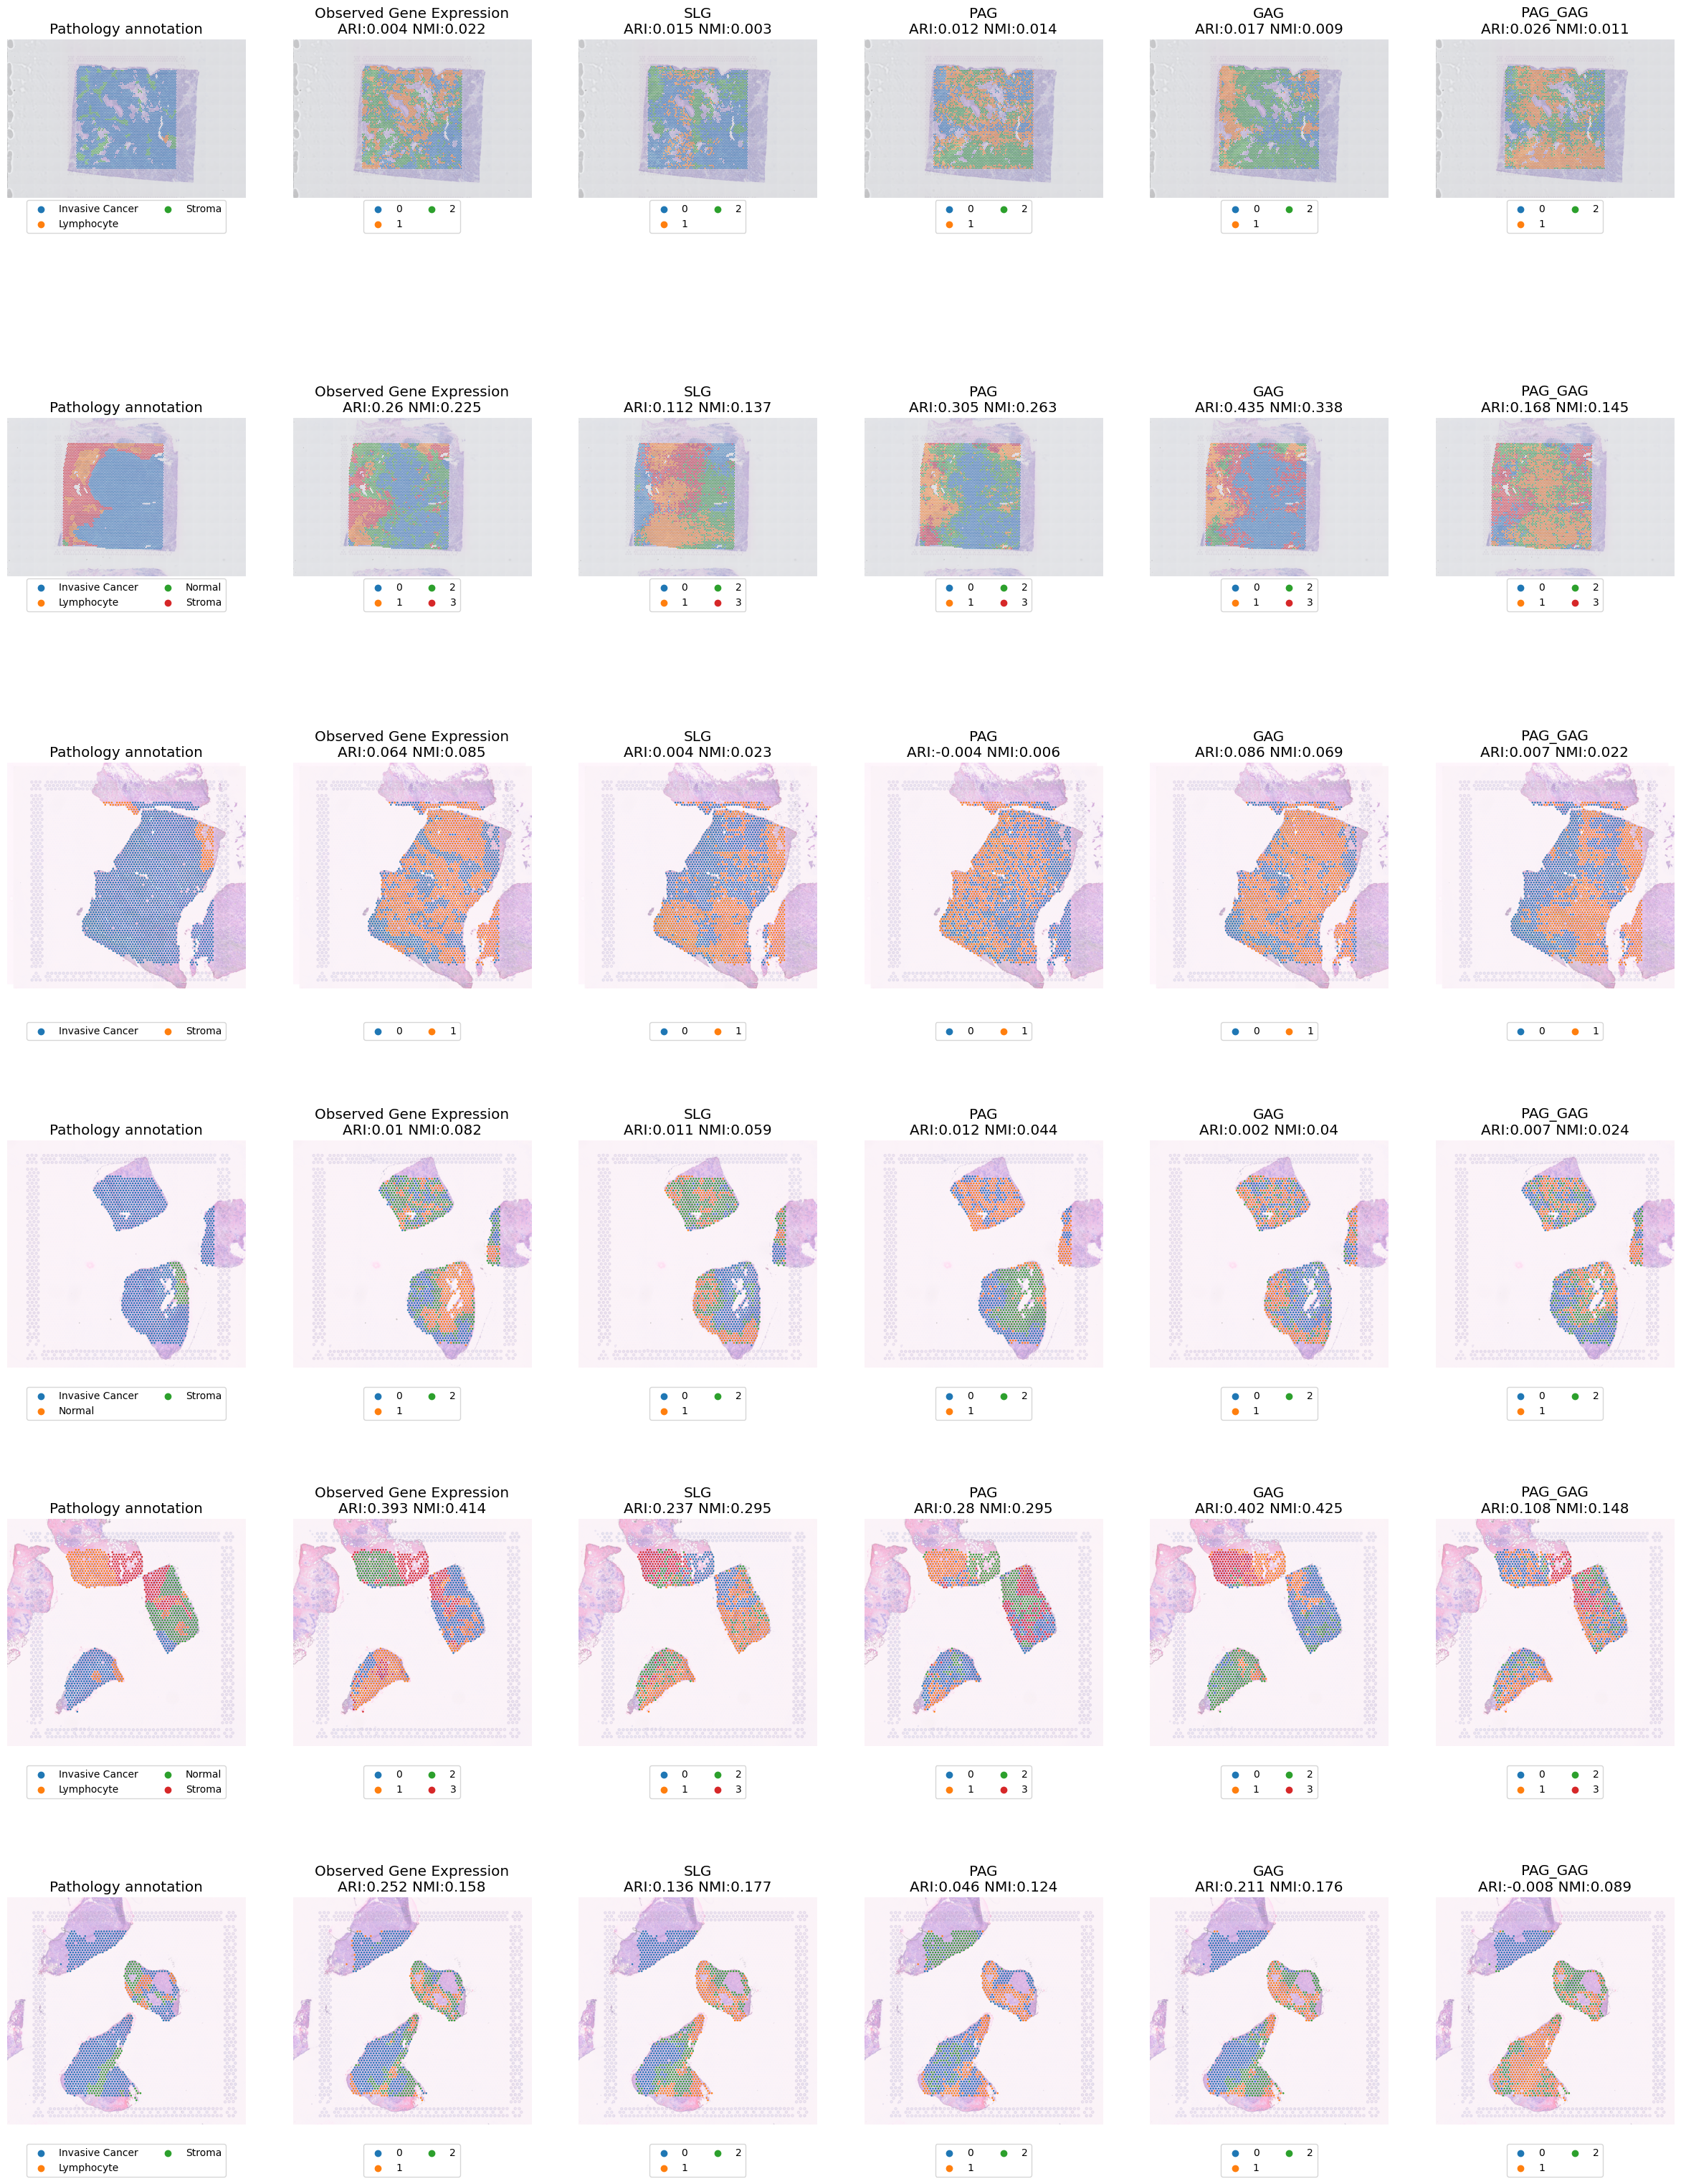

In [27]:
# Assuming Space_region_detection is a function defined elsewhere in your code
name_slides = ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535']

# Lists to collect ARI, NMI, method names, and name_slides
aris = []
nmis = []
methods = []
name_slides_list = []

fig, axs = plt.subplots(len(name_slides), 6, figsize=(30, 40))

# Loop over folds
for fold in range(len(name_slides)):
    name = name_slides[fold]
    
    # Ground Truth (Pathology annotation)
    gt = sc.read_h5ad(f"../Results/Graphconstruct/gt_PAG_{name}.h5ad")
    tmp = sc.read_h5ad(f"../Dataset/BC_visium/{name}.h5ad")
    gt.uns = tmp.uns
    sq.pl.spatial_scatter(gt, color="Grouped annotations", frameon=False, title=f"Pathology annotation", img_alpha=0.4,
                          legend_fontsize="x-large", ax=axs[fold][0])
    axs[fold][0].set_title("Pathology annotation", fontsize="x-large")  # Set title font size


    # Observation
    # print("Observation Gene Expression.")
    gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
    aris.append(pred_ari)
    nmis.append(pred_nmi)
    methods.append("Observation")
    name_slides_list.append(name)
    sq.pl.spatial_scatter(gt, color="cluster", title=f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", img_alpha=0.4,
                  frameon=False, legend_fontsize="large", ax=axs[fold][1])
    axs[fold][1].set_title(f"Observed Gene Expression\nARI:{pred_ari} NMI:{pred_nmi}", fontsize="x-large")  # Set title font size
    

    # Prediction
    for i, model_name in enumerate(["SLG", "PAG", "GAG", "PAG_GAG"]):
        pred = sc.read_h5ad(f"../Results/Graphconstruct/pred_{model_name}_{name}.h5ad")
        gt = sc.read_h5ad(f"../Results/Graphconstruct/gt_{model_name}_{name}.h5ad")
        gt.X = pred.X
        gt.uns = tmp.uns

        # # Rename models for better visualization
        # model_name_display = {
        #     "stimage": "STimage",
        #     "stnet": "STNet",
        #     "hist2st": "Hist2ST",
        #     "histogene": "HisToGene",
        #     "deepspace": "DeepSpaCE",
        #     "deeppt": "DeepPT",
        #     "bleep": "BLEEP"
        # }.get(model_name, model_name)
        
        gt, pred_ari, pred_nmi = Space_region_detection(gt, title="Predicted Gene Expression")
        aris.append(pred_ari)
        nmis.append(pred_nmi)
        # methods.append(model_name_display)
        name_slides_list.append(name)
        
        sq.pl.spatial_scatter(gt, color="cluster", title=f"{model_name}\nARI:{pred_ari} NMI:{pred_nmi}", img_alpha=0.4, 
                frameon=False, legend_fontsize="x-large", ax=axs[fold][i+2])
        ax=axs[fold][i+2].set_title(f"{model_name}\nARI:{pred_ari} NMI:{pred_nmi}", fontsize="x-large")  # Set title font size
        gc.collect()
    
    for i in range(6):
        for j in range(6):
            # Move legend to the bottom of the plot
            axs[j][i].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
        
    plt.savefig(f"Graphconstruct_clustering.pdf")
    gc.collect()

# # Create a DataFrame at the end
# result_df = pd.DataFrame({'Name_Slides': name_slides_list, 'Method': methods, 'ARI': aris, 'NMI': nmis})
# result_df.to_csv("cluster_results.csv", index=False)
